In [47]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2019, 6, 17)

df = web.DataReader("SPY", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-06-11,291.399994,288.179993,290.989990,288.899994,58641300.0,288.899994
2019-06-12,289.260010,287.820007,288.640015,288.390015,47096300.0,288.390015
2019-06-13,289.980011,288.619995,289.399994,289.579987,48945200.0,289.579987
2019-06-14,289.929993,288.410004,289.260010,289.260010,52314300.0,289.260010
2019-06-17,290.220001,289.179993,289.519989,289.369995,36107639.0,289.369995


In [48]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail(10)

Date
2019-06-04    279.207524
2019-06-05    279.459677
2019-06-06    279.729234
2019-06-07    280.043022
2019-06-10    280.340640
2019-06-11    280.631285
2019-06-12    280.897117
2019-06-13    281.140002
2019-06-14    281.415530
2019-06-17    281.686682
Name: Adj Close, dtype: float64

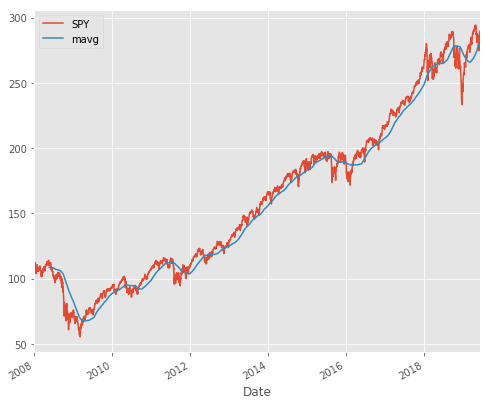

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='SPY')
mavg.plot(label='mavg')
plt.legend()

In [50]:
rets = close_px / close_px.shift(1) - 1
rets.head()

Date
2008-01-02         NaN
2008-01-03   -0.000483
2008-01-04   -0.024506
2008-01-07   -0.000849
2008-01-08   -0.016149
Name: Adj Close, dtype: float64

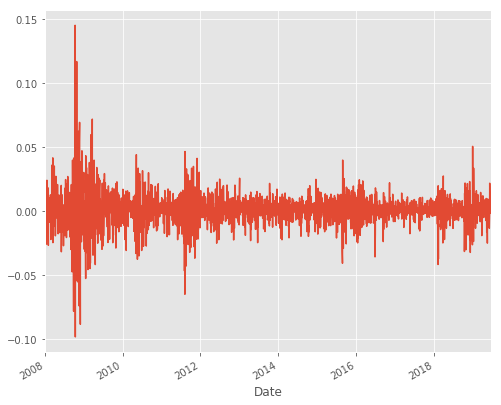

In [51]:
rets.plot(label='return')

In [52]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-01-02,146.990005,143.880005,146.529999,144.929993,204935600.0,114.888565
2008-01-03,145.490005,144.070007,144.910004,144.860001,125133300.0,114.833084
2008-01-04,143.440002,140.910004,143.339996,141.309998,232330900.0,112.018936
2008-01-07,142.229996,140.100006,141.809998,141.190002,234991000.0,111.923813
2008-01-08,142.899994,138.440002,142.080002,138.910004,326365700.0,110.116409


In [53]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2008-01-02,114.888565,204935600.0,2.145864,-1.091931
2008-01-03,114.833084,125133300.0,0.980256,-0.034506
2008-01-04,112.018936,232330900.0,1.790389,-1.416212
2008-01-07,111.923813,234991000.0,1.508598,-0.437201
2008-01-08,110.116409,326365700.0,3.210706,-2.231136


In [54]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

(2884, 4)
Dimension of X (2855, 4)
Dimension of y (2855,)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)


# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
    
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [57]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9864901722707896
The quadratic regression 2 confidence is  0.9865016533526142
The quadratic regression 3 confidence is  0.9845703934739348
The knn regression confidence is  0.9792157571572057


In [58]:
# Printing the forecast
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set, confidencereg, forecast_out)

[290.35952511 289.97657413 288.94286518 290.36487661 283.25463961
 285.83938414 287.36492648 290.11255579 288.19373099 286.6523203
 289.15903247 288.32693607 284.64203239 285.59032082 283.19403904
 280.67300077 281.68197022 277.79548556 277.10403894 282.7793509
 285.49706675 287.27389739 290.07603902 291.67191246 291.89156923
 291.15073017 292.27453188 291.95753076 292.18364268] 0.9864901722707896 29


In [0]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

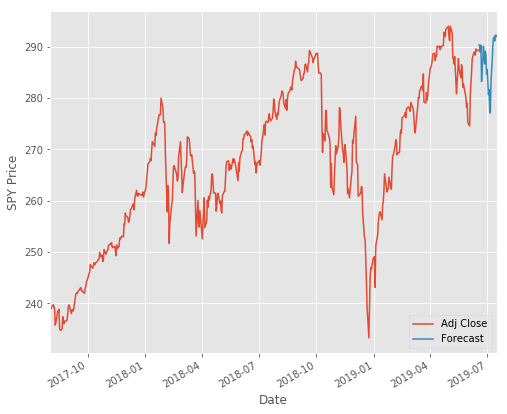

In [60]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('SPY Price')
plt.show()


[https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7](https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7)

Bought a 280 Put 7/19 expiration $224 June 17, 2019